# NeqSim in jupyter

NeqSim can be run from jupyter by using the py4j python package. The JavaGateway must be started before the program can be run. Initially we connect to Java and import numpy and matplotlib for plotting.

In [ ]:
import neqsim

from py4j.java_gateway import JavaGateway
neqsim =  JavaGateway().jvm.neqsim

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
matplotlib inline

##Example 1 Setting up a thermodynamic calculation using NeqSim

In [ ]:
thermoSystem = neqsim.thermo.system.SystemSrkEos(280.0,10.0)
thermoSystem.addComponent("methane", 10.0)
thermoSystem.addComponent("water", 4.0)

thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.TPflash()

#thermoSystem.display()

gasEnthalpy = thermoSystem.getPhase(0).getEnthalpy()

thermoSystem.initPhysicalProperties("Viscosity")
gasViscosity = thermoSystem.getPhase(0).getViscosity("kg/msec")

print("Gas enthalpy ", gasEnthalpy)
print("Gas viscosity ", gasViscosity)

##Example 2 Calculation of a phase envelope using NeqSim

In [ ]:
thermoSystem = neqsim.thermo.system.SystemSrkEos(280.0,10.0)
thermoSystem.addComponent("nitrogen", 1.0)
thermoSystem.addComponent("methane", 70.0)
thermoSystem.addComponent("ethane", 4.0)
thermoSystem.addComponent("propane", 2.0)
thermoSystem.addComponent("i-butane", 1.0)
thermoSystem.addComponent("n-butane", 1.0)

thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.calcPTphaseEnvelope()

plt.plot(list(thermoOps.getOperation().get("dewT")),list(thermoOps.getOperation().get("dewP")), label="dew point")
plt.plot(list(thermoOps.getOperation().get("bubT")),list(thermoOps.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [\u00B0C]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()

##Example 3 Calculation of hydrate equilibrium temperature using NeqSim

In [ ]:
thermoSystem = neqsim.thermo.system.SystemSrkEos(280.0,60.0)
thermoSystem.addComponent("methane", 90.0)
thermoSystem.addComponent("ethane", 10.0)
thermoSystem.addComponent("propane", 1.0)
thermoSystem.addComponent("water", 4.0)
thermoSystem.setHydrateCheck(True);
thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.hydrateFormationTemperature()

print("Hydrate equilibrium temperature ", thermoSystem.getTemperature()-273.15, " C")

##Example 4 Oil characterization

gas density  74.40477073100676
oil density  712.8713243065952


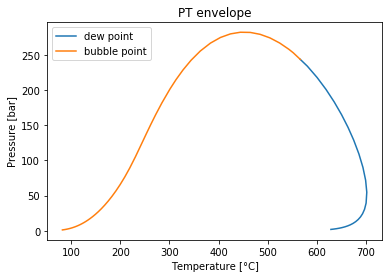

In [7]:
thermoSystem = neqsim.thermo.system.SystemSrkEos(280.0,60.0)
thermoSystem.addComponent("nitrogen", 2.0)
thermoSystem.addComponent("CO2", 1.0)
thermoSystem.addComponent("methane", 10.0)
thermoSystem.addComponent("ethane", 10.0)
thermoSystem.addComponent("propane", 1.0)
thermoSystem.addTBPfraction("C6", 0.428, 86.178 / 1000.0, 0.664);
thermoSystem.addTBPfraction("C7", 0.626, 96.00 / 1000.0, 0.738);
thermoSystem.addTBPfraction("C8", 0.609, 107.0 / 1000.0, 0.765);
thermoSystem.addTBPfraction("C9", 0.309, 121.0 / 1000.0, 0.781);
thermoSystem.addPlusFraction("C10", 5.137, 231.0 / 1000.0, 0.8301);
thermoSystem.getCharacterization().getLumpingModel().setNumberOfLumpedComponents(12);
thermoSystem.getCharacterization().characterisePlusFraction();
thermoSystem.setMixingRule(2)

thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.TPflash()

#thermoSystem.display()

thermoSystem.initPhysicalProperties("Density")
gasDensity = thermoSystem.getPhase("gas").getDensity("kg/m3")
oilDensity = thermoSystem.getPhase("oil").getDensity("kg/m3")

print("gas density ", gasDensity)
print("oil density ", oilDensity)

thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.calcPTphaseEnvelope()

plt.plot(list(thermoOps.getOperation().get("dewT")),list(thermoOps.getOperation().get("dewP")), label="dew point")
plt.plot(list(thermoOps.getOperation().get("bubT")),list(thermoOps.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [\u00B0C]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()

##Example 5 Process simulation

In [8]:
processEquipment = neqsim.processSimulation.processEquipment

testSystem = neqsim.thermo.system.SystemSrkEos((273.15+50.0),50.00);
testSystem.addComponent("methane", 900.00);
testSystem.addComponent("ethane", 200.00);
testSystem.addComponent("n-hexane", 200.0);
testSystem.addComponent("n-nonane", 200.0);
testSystem.addComponent("nC10", 20.0);
testSystem.addComponent("nC13", 10.0);
testSystem.setMixingRule(2);

stream_1 = processEquipment.stream.Stream("Stream1", testSystem);
        
mixerHP = processEquipment.mixer.StaticMixer("Mixer HP");
mixerHP.addStream(stream_1);
        
separator = processEquipment.separator.Separator("Separator 1", mixerHP.getOutStream());
        
LP_valve = processEquipment.valve.ThrottlingValve("LPventil", separator.getLiquidOutStream());
LP_valve.setOutletPressure(5.0);
        
LPseparator = processEquipment.separator.Separator("Separator 1", LP_valve.getOutStream());
        
LPcompressor = processEquipment.compressor.Compressor(LPseparator.getGasOutStream());
LPcompressor.setOutletPressure(50.0);
        
heaterLP =  processEquipment.heatExchanger.Heater(LPcompressor.getOutStream());
heaterLP.setOutTemperature(270.25);
        
stream_2 =  processEquipment.stream.Stream(heaterLP.getOutStream());
stream_2.setName("cooled gas");
        
gasScrubber = processEquipment.separator.GasScrubberSimple("Scrubber", stream_2);
        
stream_3 = processEquipment.stream.Stream(gasScrubber.getLiquidOutStream());
stream_3.setName("liq from scrubber gas");
        
mixerHP.addStream(stream_3);
        
mixer = processEquipment.mixer.StaticMixer("Mixer export");
mixer.addStream(separator.getGasOutStream());
mixer.addStream(gasScrubber.getGasOutStream());
        
HPcompressor = processEquipment.compressor.Compressor(mixer.getOutStream());
HPcompressor.setOutletPressure(200.0);
        
operations =  neqsim.processSimulation.processSystem.ProcessSystem();
operations.add(stream_1);
operations.add(mixerHP);
operations.add(separator);
operations.add(LP_valve);
operations.add(LPseparator);
operations.add(LPcompressor);
operations.add(heaterLP);
operations.add(stream_2);
operations.add(gasScrubber);
operations.add(stream_3);
operations.add(mixer);
operations.add(HPcompressor);
        
operations.run();

print("LP compressor power ", LPcompressor.getPower()/1000.0, " kW")
print("HP compressor power ", HPcompressor.getPower()/1000.0, " kW")

LP compressor power  2141.7510040196507  kW
HP compressor power  9984.983771274849  kW



##Example 6 Create pS and pH diagram

In [ ]:
thermoSystem = neqsim.thermo.system.SystemSrkEos(280.0,10.0)
thermoSystem.addComponent("methane", 10.0)
thermoSystem.addComponent("ethane", 4.0)

thermoOps = neqsim.thermodynamicOperations.ThermodynamicOperations(thermoSystem)
thermoOps.TPflash()

def enthalpy(P):
    thermoSystem.setPressure(P)
    thermoSystem.init(3)
    return thermoSystem.getEnthalpy("kJ/kg")

def entropy(P):
    thermoSystem.setPressure(P)
    thermoSystem.init(3)
    return thermoSystem.getEntropy("kJ/kgK")

pressure = np.arange(1.0, 200.0, 5.0)
enthalpy = [enthalpy(P) for P in pressure]
entropy = [entropy(P) for P in pressure]

plt.subplot(2, 1, 1)
plt.plot(pressure, enthalpy)
plt.xlabel('Pressure [bara]')
plt.ylabel('Enthalpy [kJ/kg]')

plt.subplot(2, 1, 2)
plt.plot(pressure, entropy)
plt.xlabel('Pressure [bara]')
plt.ylabel('Entropy [kJ/kgK]')
    

Example 7 Using the neqsim Python package (pip distribution neqsim)

In [3]:
import neqsim
from neqsim.thermoTools import *

fluid1 = fluid('srk')
fluid1.addComponent('methane',10.0)
fluid1.addComponent('n-heptane',2.0)
fluid1.addComponent('water',3.0)
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)
TPflash(fluid1)
show(fluid1)

In [ ]:
fluid1 = fluid('srk')
fluid1.addComponent('methane',10.0)
fluid1.addComponent('n-heptane',2.0)
fluid1.setMixingRule(2)
TPflash(fluid1)

print('density ',fluid1.getPhase('gas').getDensity(),' kg/m3')

In [ ]:
fluid1 = fluid('srk')
fluid1.addComponent('n-heptane',49.39)
#fluid1.addComponent('methane',50.61)
fluid1.setMixingRule(2)
fluid1.setTemperature(267.12)
fluid1.setPressure(17.91)
#fluid1.useVolumeCorrection(True)
TPflash(fluid1)
fluid1.initPhysicalProperties()

print('density ',fluid1.getPhase('oil').getDensity(),' kg/m3')
print('conductivity ',fluid1.getPhase('oil').getConductivity())
fluid1.getPhase(0).getPhysicalProperties().setConductivityModel("PFCT");
fluid1.initPhysicalProperties()
print('conductivity ',fluid1.getPhase('oil').getConductivity())